In [65]:
from pathlib import Path
import pandas as pd
from datetime import datetime

#use concat to merge all of files together
list_stacked = pd.DataFrame() 
current_path = Path()/'CSV'
for folder in current_path.absolute().glob('*'):
    for file in folder.glob('H_lvr_land_A.csv'):
        data = pd.read_csv(file)[1:]
        list_stacked = pd.concat([list_stacked, data])

#Originally, there are 33 columns in the file; select 18 columns which need to be analyzed
data = list_stacked[['鄉鎮市區', '土地位置建物門牌', '土地移轉總面積平方公尺', '交易年月日', '總樓層數', '建物型態', '建物移轉總面積平方公尺', '總價元',
                     '單價元平方公尺', '主建物面積']]

#坪 is the most popular unit that Taiwanese to measure the property, so we need to transfer from meter squared to 坪
data = data.copy()
data = data[data['鄉鎮市區'].notna()]
data['土地移轉總面積坪'] = data['土地移轉總面積平方公尺'].astype(float)*0.3025
data['建物移轉總面積坪'] = data['建物移轉總面積平方公尺'].astype(float)*0.3025
data['單價元坪'] = data['單價元平方公尺'].astype(float)*3.3058
data['主建物面積坪'] = data['主建物面積'].astype(float)*0.3025
data['總價元'] = data['總價元'].astype(float)
data['交易年月日'] = pd.to_datetime((data['交易年月日'].astype(int)+19110000).astype(str), format = '%Y%m%d', errors='coerce') #transfer to date format
condition = (data['交易年月日'] >= '2020-10-01') & (data['交易年月日'] <= '2023-09-30') # filter period from 2022-10-01 to 2023-09-30
data = data[condition]

data['Year'] = data['交易年月日'].dt.year.fillna(0).astype(int)
data['Quarter'] = data['交易年月日'].dt.quarter.fillna(0).astype(int)
data['Month'] = data['交易年月日'].dt.month.fillna(0).astype(int).map("{:02}".format)
data['Day'] = data['交易年月日'].dt.day.fillna(0).astype(int)

# # #----------------------------------------------------------------------------------------------------------------------------
data = data.where(pd.notnull(data), None)


In [66]:
lst = []
for year, month in zip(data['Year'],data['Month']):
    lst.append('-'.join(str(i) for i in [year, month]))
data['Yearmonth'] = lst
data['Yearmonth'] = pd.to_datetime(data['Yearmonth'], format='%Y-%m').dt.to_period('M')


In [67]:
# Determine the user's operating system environment.
from sys import platform
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

if platform == 'darwin':
    # Set the Chinese font
    plt.rcParams['font.family'] = 'Arial Unicode MS'  # Use the built-in Chinese font on macOS

    # Use Chinese font
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
    plt.rcParams['axes.unicode_minus'] = False  # Solve the problem of displaying negative signs

elif platform == 'win32':
    # Set the Chinese font path
    font_path = r'C:\Windows\Fonts'  # Replace it with the file path of your downloaded Chinese font

    # Set the Chinese font
    custom_font = FontProperties(fname=font_path)

    # Use Chinese font
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # Replace it with your selected traditional Chinese font
    plt.rcParams['axes.unicode_minus'] = False  # Solve the problem of displaying negative signs


In [68]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num
import numpy as np

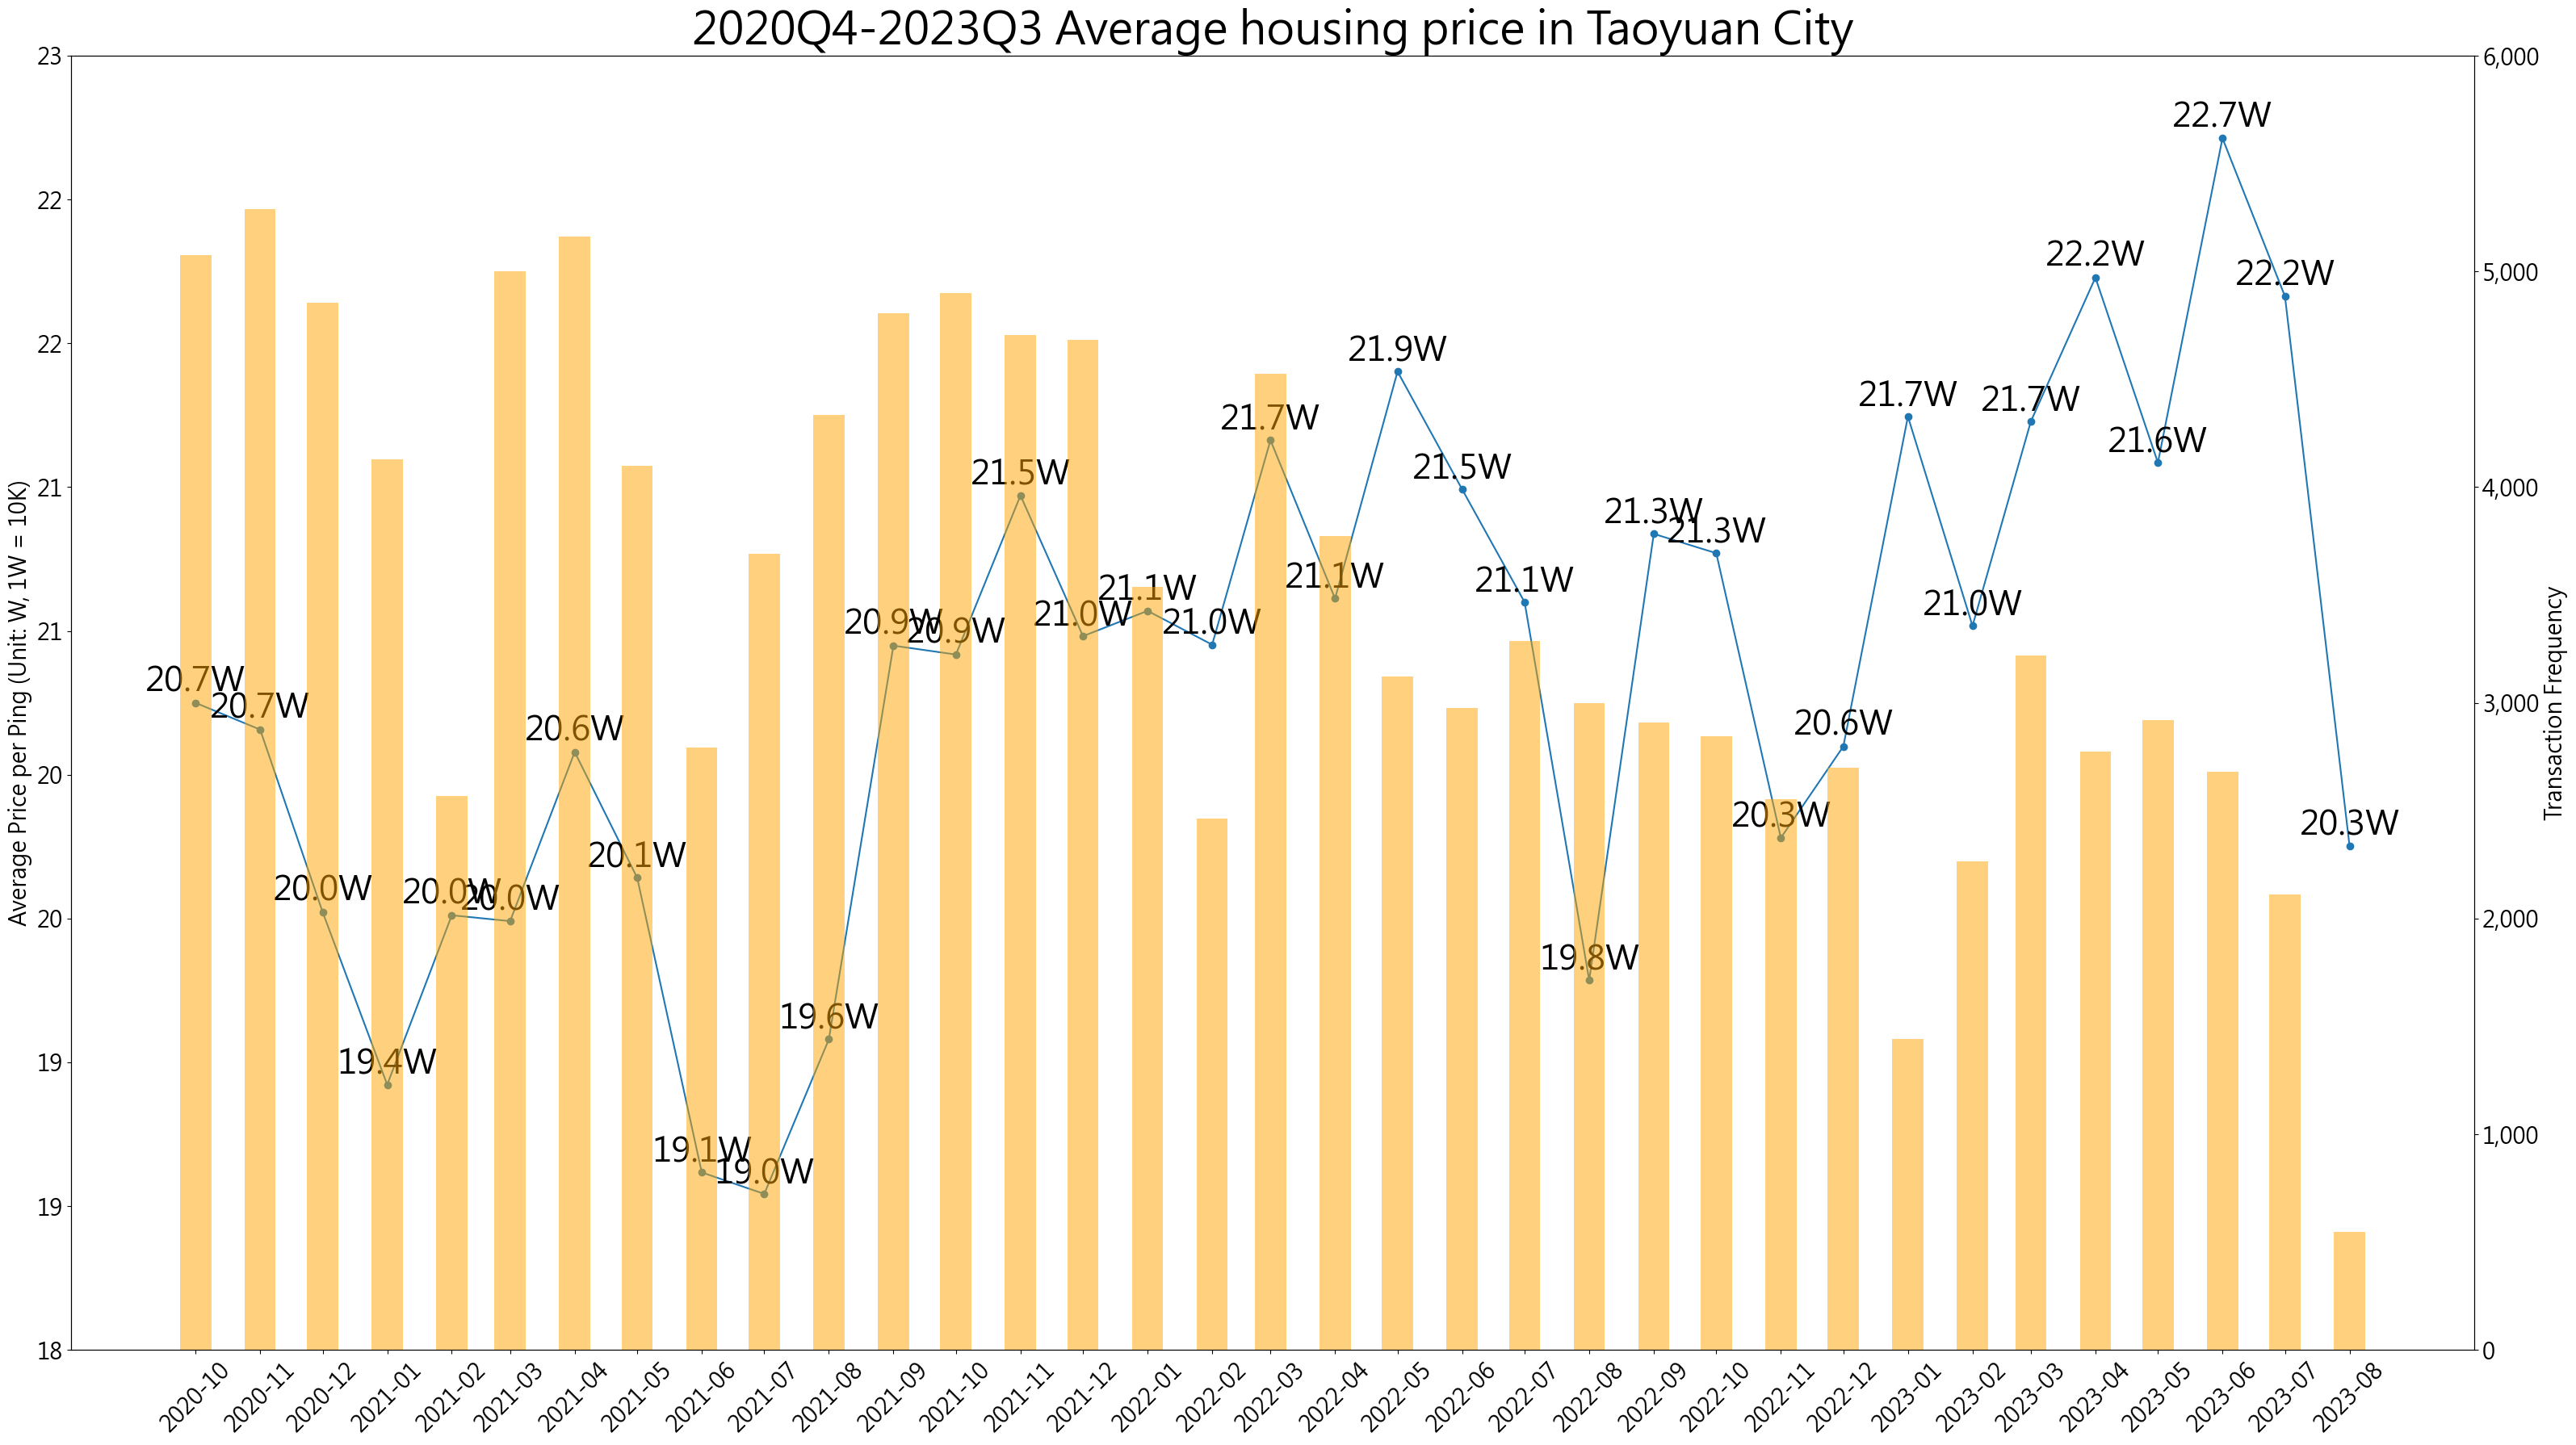

In [69]:
from matplotlib.dates import date2num
from pathlib import Path

x_values = sorted(set(lst))
dates = [datetime.strptime(date, '%Y-%m') for date in x_values]
x_values_numeric = date2num(dates)

y = list(data.groupby(['Yearmonth'])['單價元坪'].mean())
y_values = [int(i) / 10000 for i in y]

# Count the number of entries for each unique year-month combination
entry_counts = data['Yearmonth'].value_counts().sort_index()

# Plotting
fig, ax1 = plt.subplots(figsize=(32, 18))

# Line chart
ax1.plot(x_values_numeric, y_values, marker='o', label='Average Price')

# Set the x-axis ticks to be the original date strings
ax1.set_xticks(dates)
ax1.set_xticklabels(x_values, rotation=45, fontsize=20)

# Add labels and title for the line chart
ax1.set_ylabel('Average Price per Ping (Unit: W, 1W = 10K)', fontsize=20)

# Set y-axis ticks and labels
ax1.set_yticks(ax1.get_yticks())
ax1.set_yticklabels([f'{int(i):,}' for i in ax1.get_yticks()], fontsize=20)

title = '2020Q4-2023Q3 Average housing price in Taoyuan City'
ax1.set_title(title, fontsize=40)

# Annotate the data points on the line chart
for i, txt in enumerate(y_values):
    ax1.annotate(f'{txt:.1f}W', (x_values_numeric[i], y_values[i]),
                 textcoords="offset points", xytext=(0, 10), ha='center', size=30)

# Bar chart
ax2 = ax1.twinx()  # Create a second y-axis to overlay the bar chart
ax2.bar(x_values_numeric, entry_counts, alpha=0.5, color='orange', width=15)

# Add labels and title for the bar chart
ax2.set_ylabel('Transaction Frequency', fontsize=20)

# Set y-axis ticks and labels for the second y-axis
ax2.set_yticks(ax2.get_yticks())
ax2.set_yticklabels([f'{int(i):,}' for i in ax2.get_yticks()], fontsize=20)

# Adjust layout to prevent label overlap
fig.tight_layout()


# save the plot with title named
path_to_save_file = Path().absolute()/"PNG"
path_to_save_file.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist
filename = f'{title}.png'
full_path = path_to_save_file/filename
plt.savefig(full_path)

# Show the chart
plt.show()


In [70]:
# # # # #----------------------------------------------------------------------------------------------------------------------------
# data_transpose = pd.DataFrame({'Price': y_values, 'Count': entry_counts})
# data_transpose['Price'] = data_transpose['Price'].round(1)
# data_transpose['Count'] = data_transpose['Count'].apply(lambda x: f'{x:.0f}')
# pd.set_option('display.max_columns', None)
# data_transpose.transpose()

data_detail = data[['總價元', '土地移轉總面積坪', '建物移轉總面積坪', '單價元坪', '主建物面積坪']]
data_detail.loc[:,'總價元'] = data_detail['總價元']/10000
data_detail.loc[:,'單價元坪'] = data_detail['單價元坪']/10000

data_detail.describe().round(2)


,總價元,土地移轉總面積坪,建物移轉總面積坪,單價元坪,主建物面積坪
count,121740.00,121740.00,121740.00,120383.00,121740.00
mean,1395.36,80.77,37.74,20.78,25.40
std,6228.47,449.55,219.26,16.60,194.98
min,0.00,0.00,0.00,0.00,0.00
25%,434.71,5.07,2.26,13.38,0.00
50%,812.12,8.39,33.45,19.99,19.35
75%,1270.00,25.61,48.30,26.49,27.31
max,630000.00,66630.27,40154.24,2119.59,39738.41


In [71]:
transaction_area = data['鄉鎮市區'].value_counts().reset_index()
transaction_area = transaction_area.sort_values(by='count', ascending=False).reset_index(drop=True)


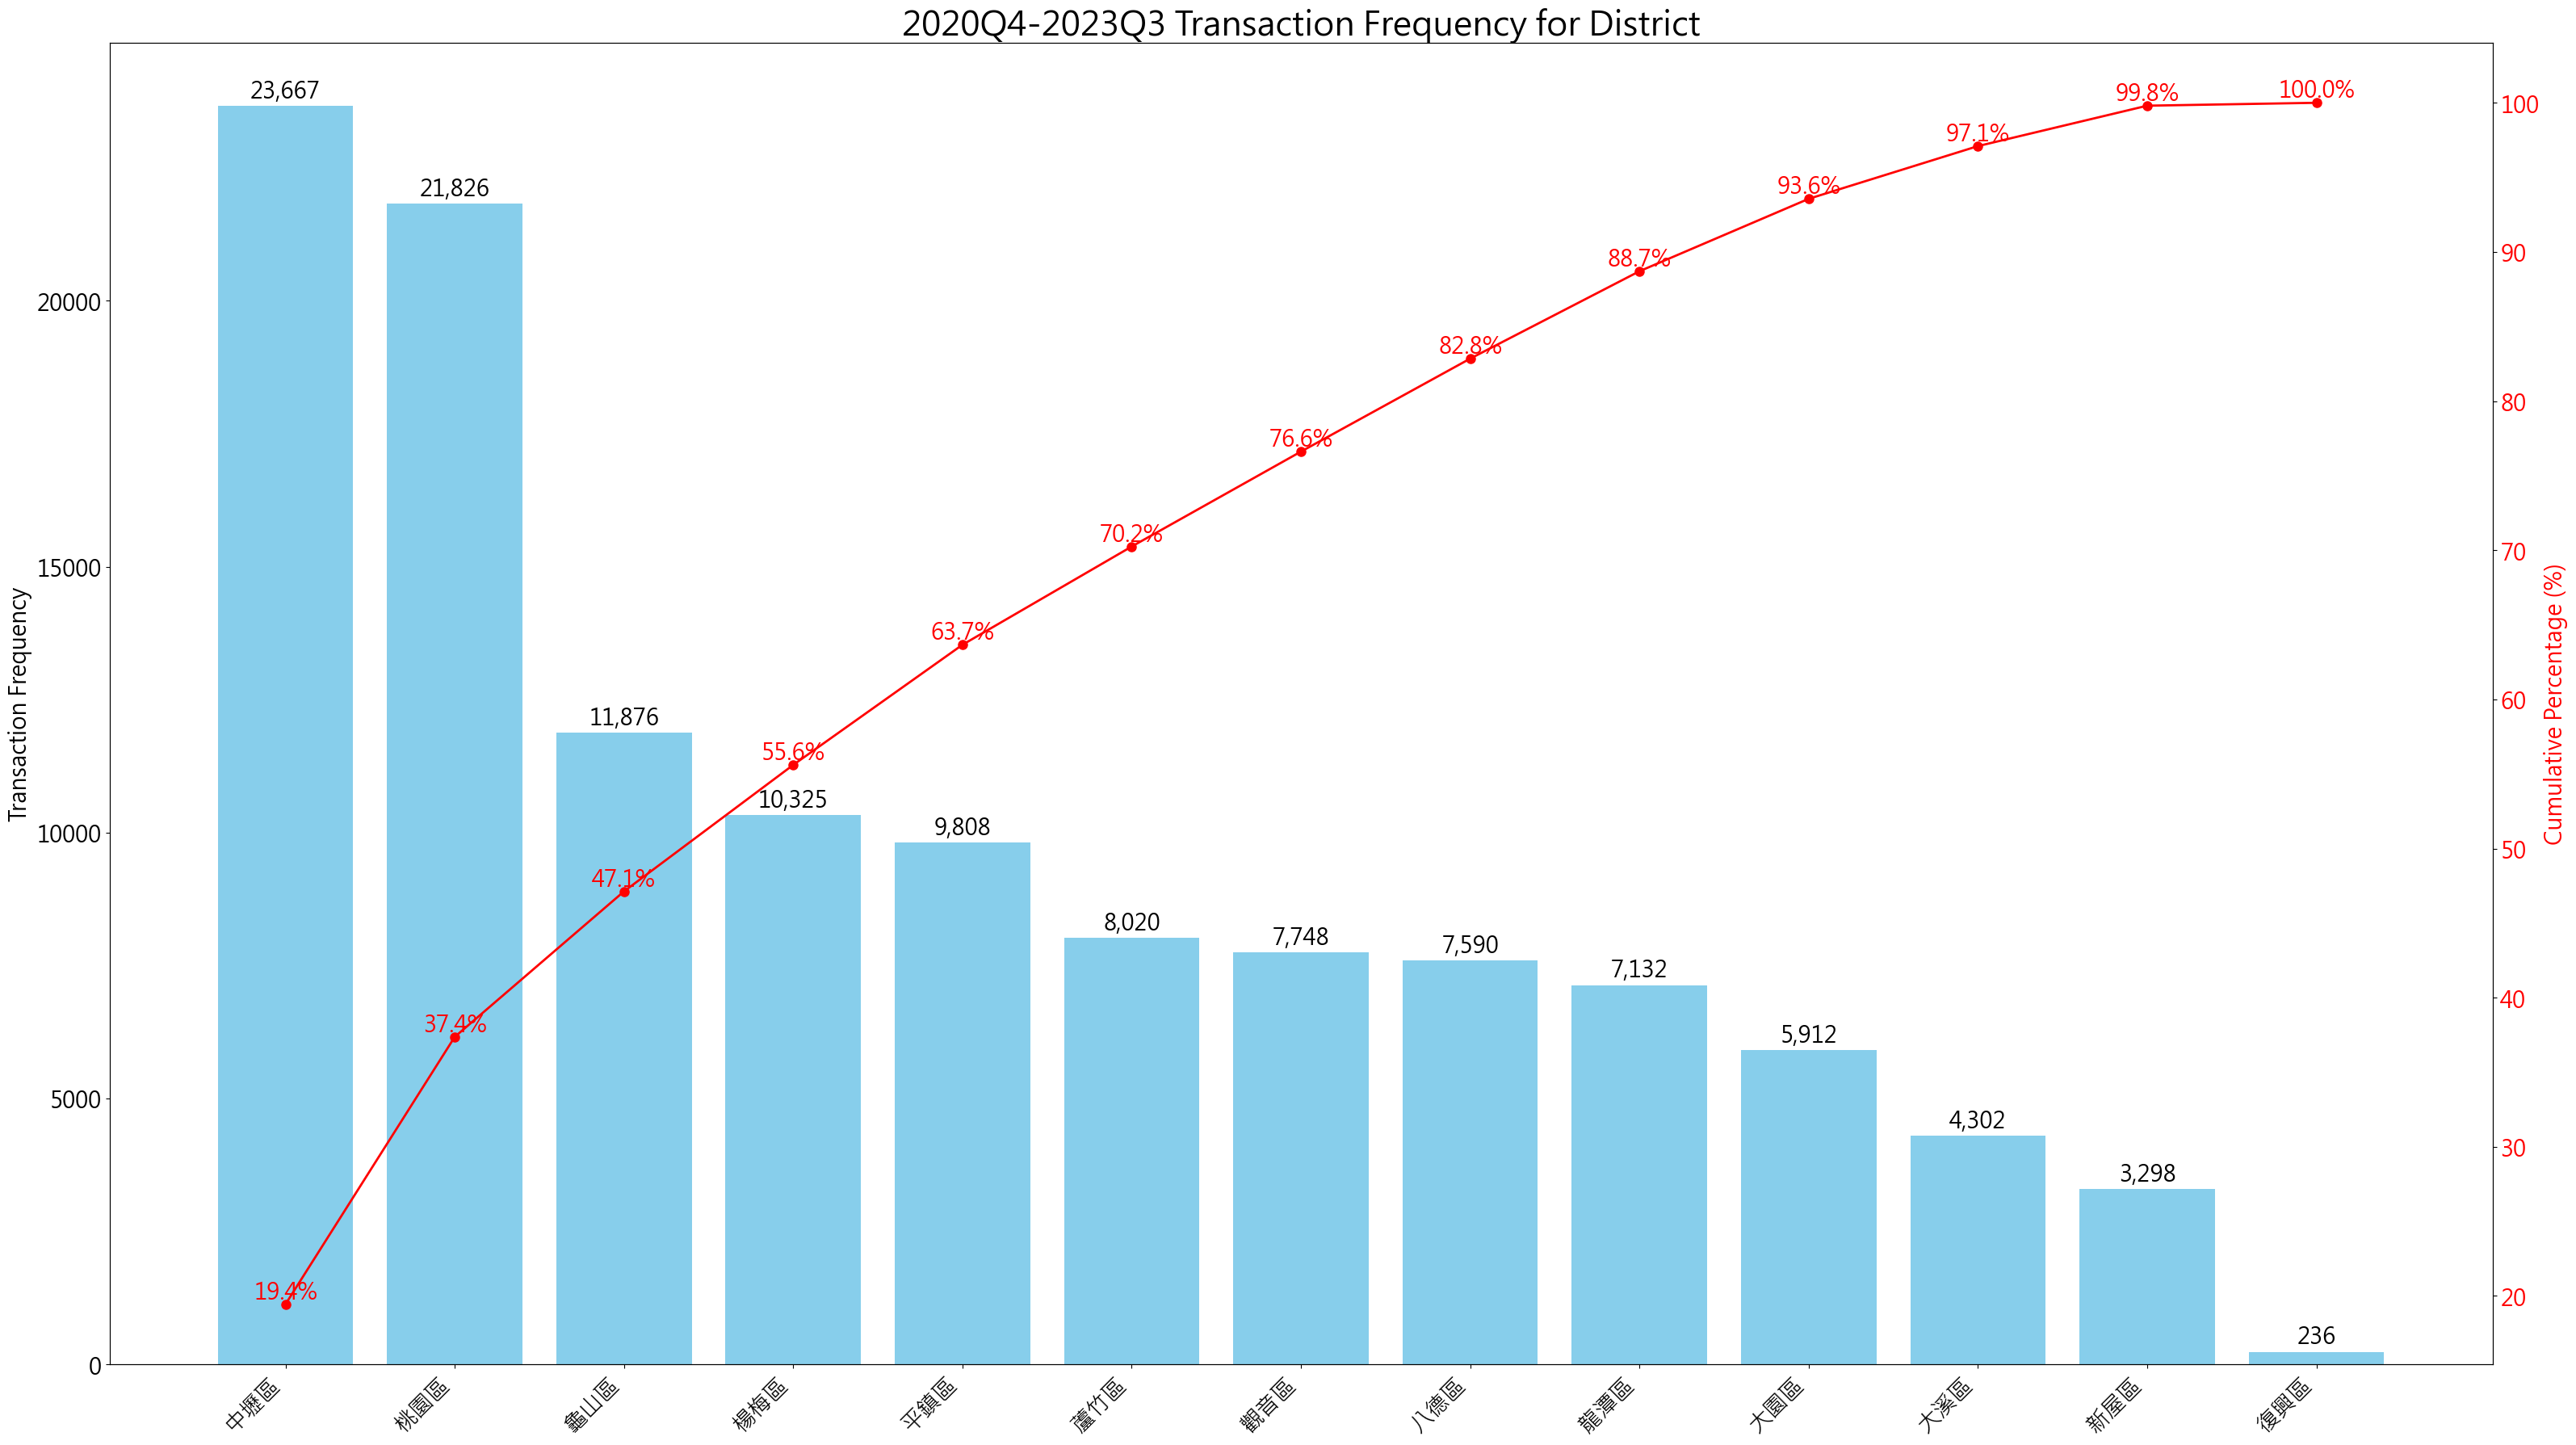

In [72]:
# Create a DataFrame
ta = pd.DataFrame(transaction_area)

# Sort DataFrame by count in descending order
ta = ta.sort_values(by='count', ascending=False)

# Calculate cumulative percentage
ta['cum_percentage'] = ta['count'].cumsum() / ta['count'].sum() * 100

# Plot the bar chart and cumulative percentage line
fig, ax1 = plt.subplots(figsize=(32, 18))
bars = ax1.bar(ta['鄉鎮市區'], ta['count'], color='skyblue')

# Add data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval + 50, f'{yval:,}', ha='center', va='bottom', fontsize=20)

# Add labels and title
ax1.set_ylabel('Transaction Frequency', fontsize=20)
title = '2020Q4-2023Q3 Transaction Frequency for District'
ax1.set_title(title, fontsize=30)

# Set tick positions and labels for the x-axis
ax1.set_xticks(ta.index)
ax1.set_xticklabels(ta['鄉鎮市區'], rotation=45, ha='right', fontsize=20)

ax1.tick_params(axis='y', labelsize=20)

# Create a secondary Y-axis for the cumulative percentage line
ax2 = ax1.twinx()
ax2.plot(ta.index, ta['cum_percentage'], color='red', marker='o', linestyle='-', linewidth=2, markersize=8)

# Add percentage data labels on the line
for x, y in zip(ta.index, ta['cum_percentage']):
    ax2.text(x, y, f'{y:.1f}%', ha='center', va='bottom', fontsize=20, color='red')

ax2.set_ylabel('Cumulative Percentage (%)', color='red', fontsize=20)
ax2.tick_params(axis='y', labelcolor='red', labelsize=20)

# # Show the plot
plt.tight_layout()

# # save the plot with title named
# path_to_save_file = Path().absolute()/"PNG"
# path_to_save_file.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist
# filename = f'{title}.png'
# full_path = path_to_save_file/filename
# plt.savefig(full_path)

plt.show()


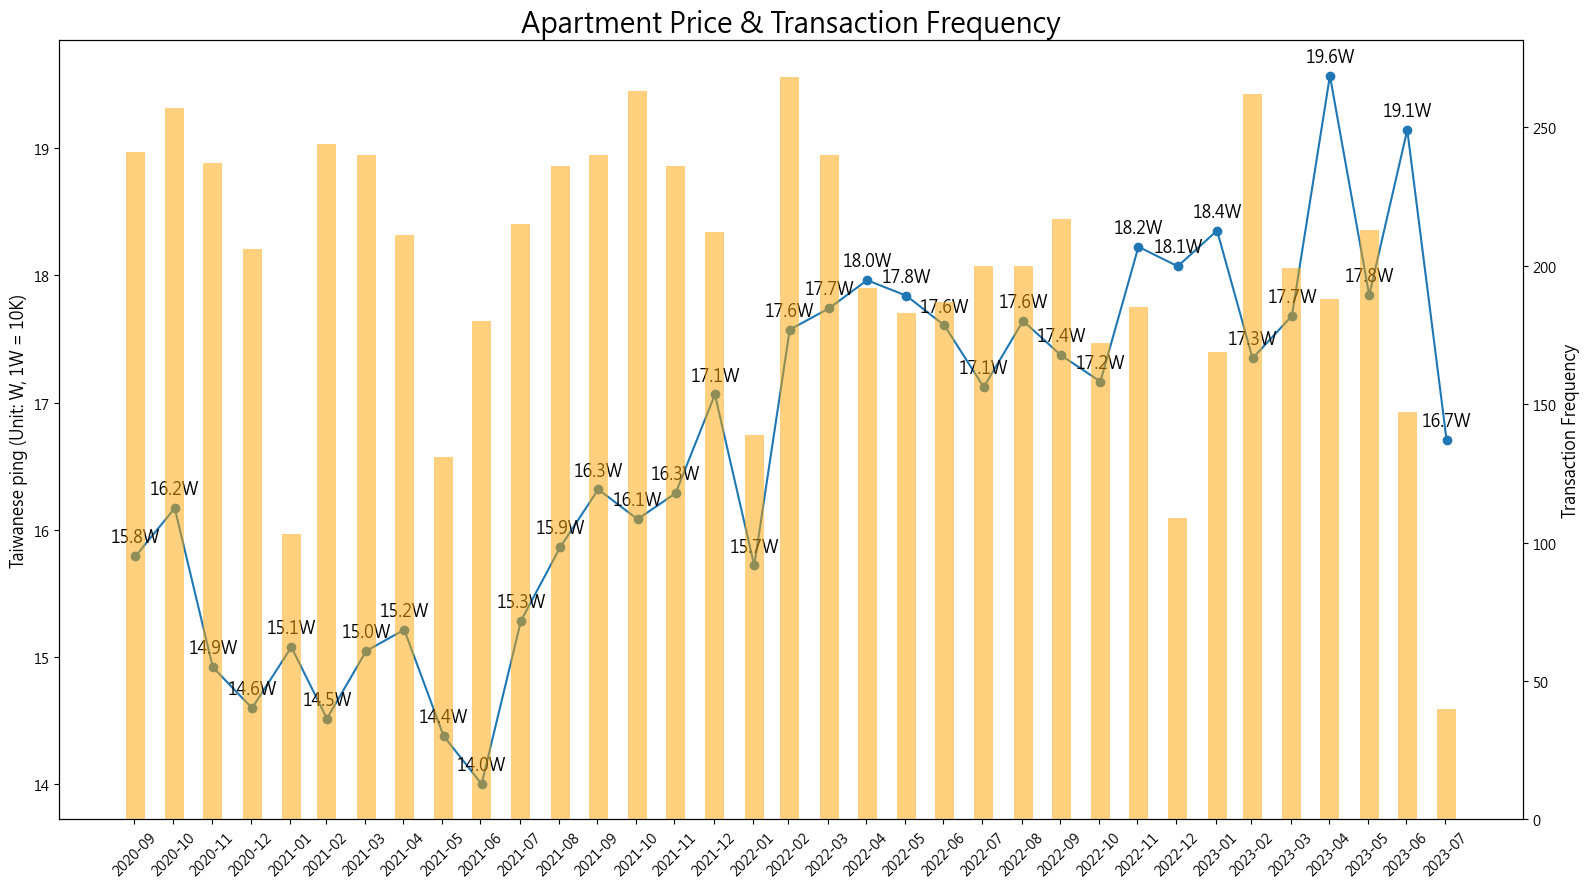

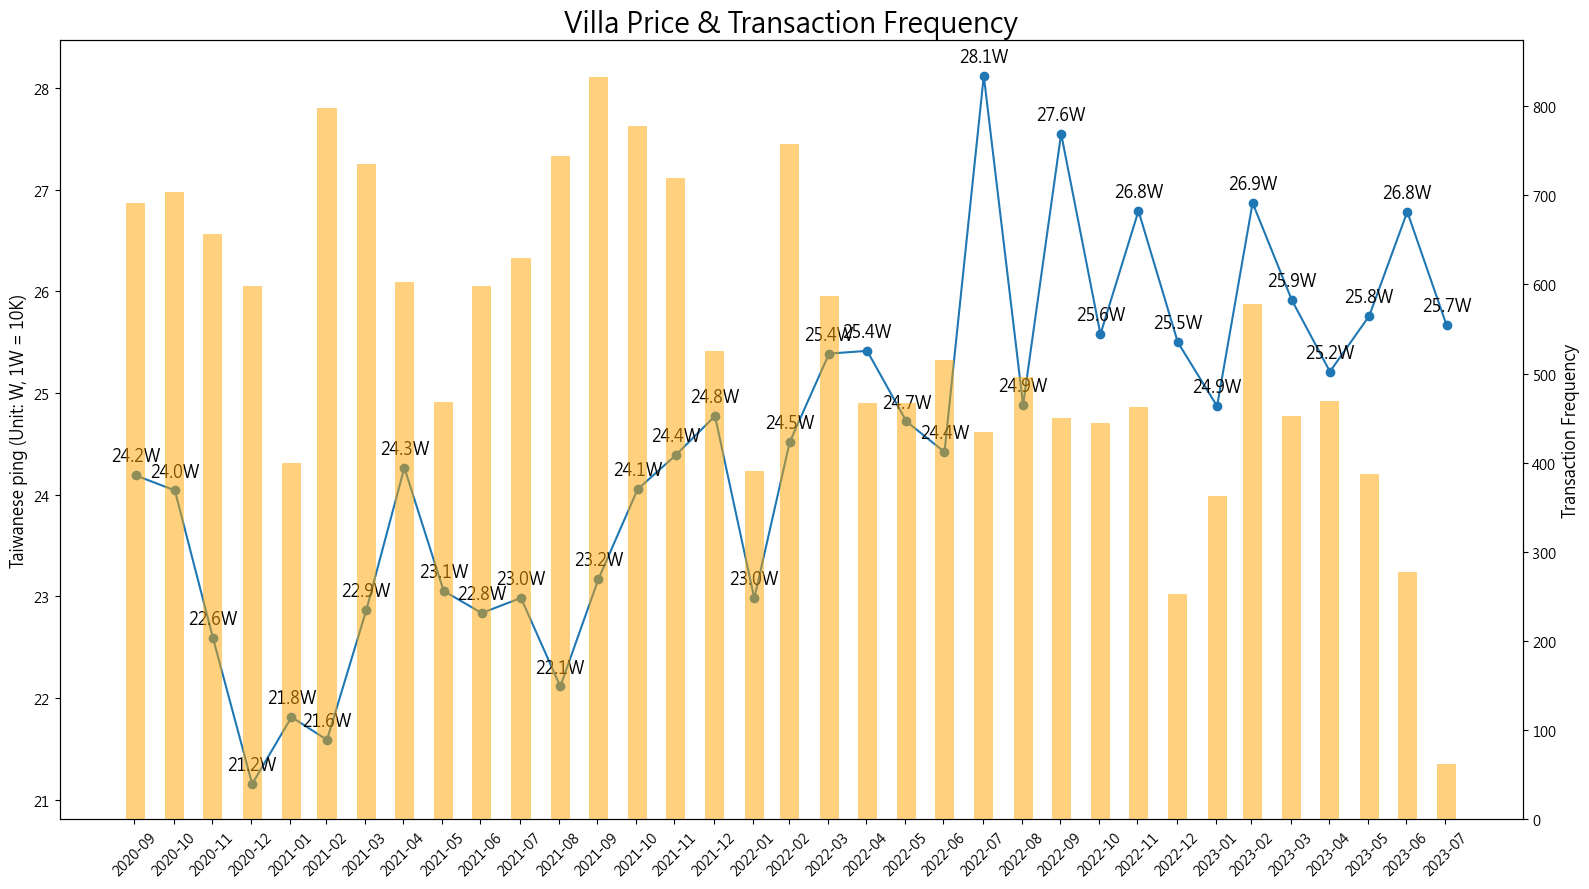

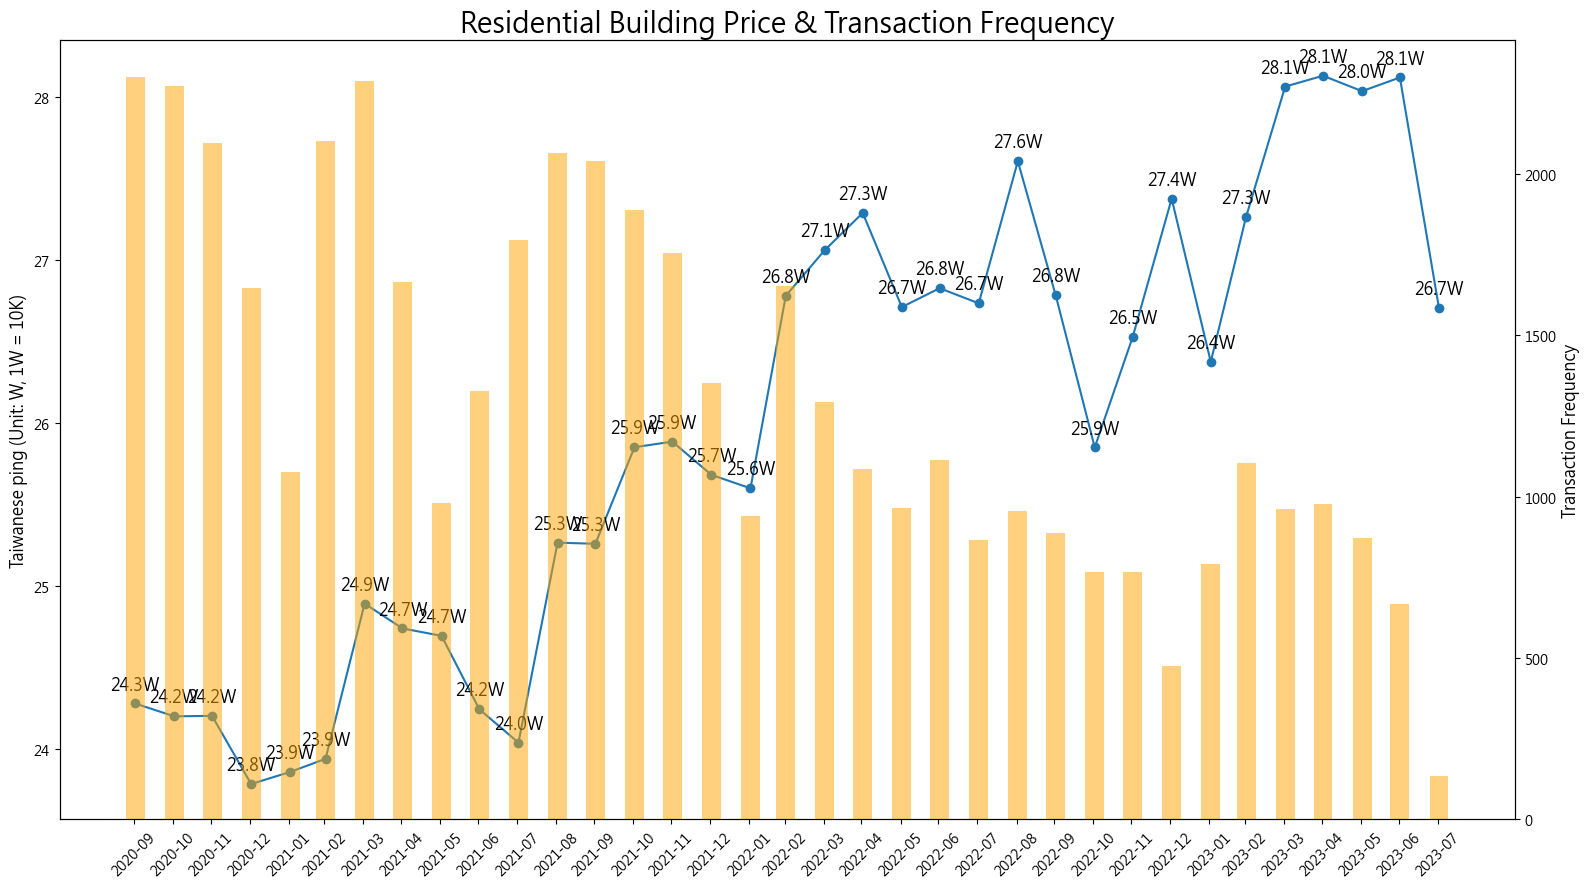

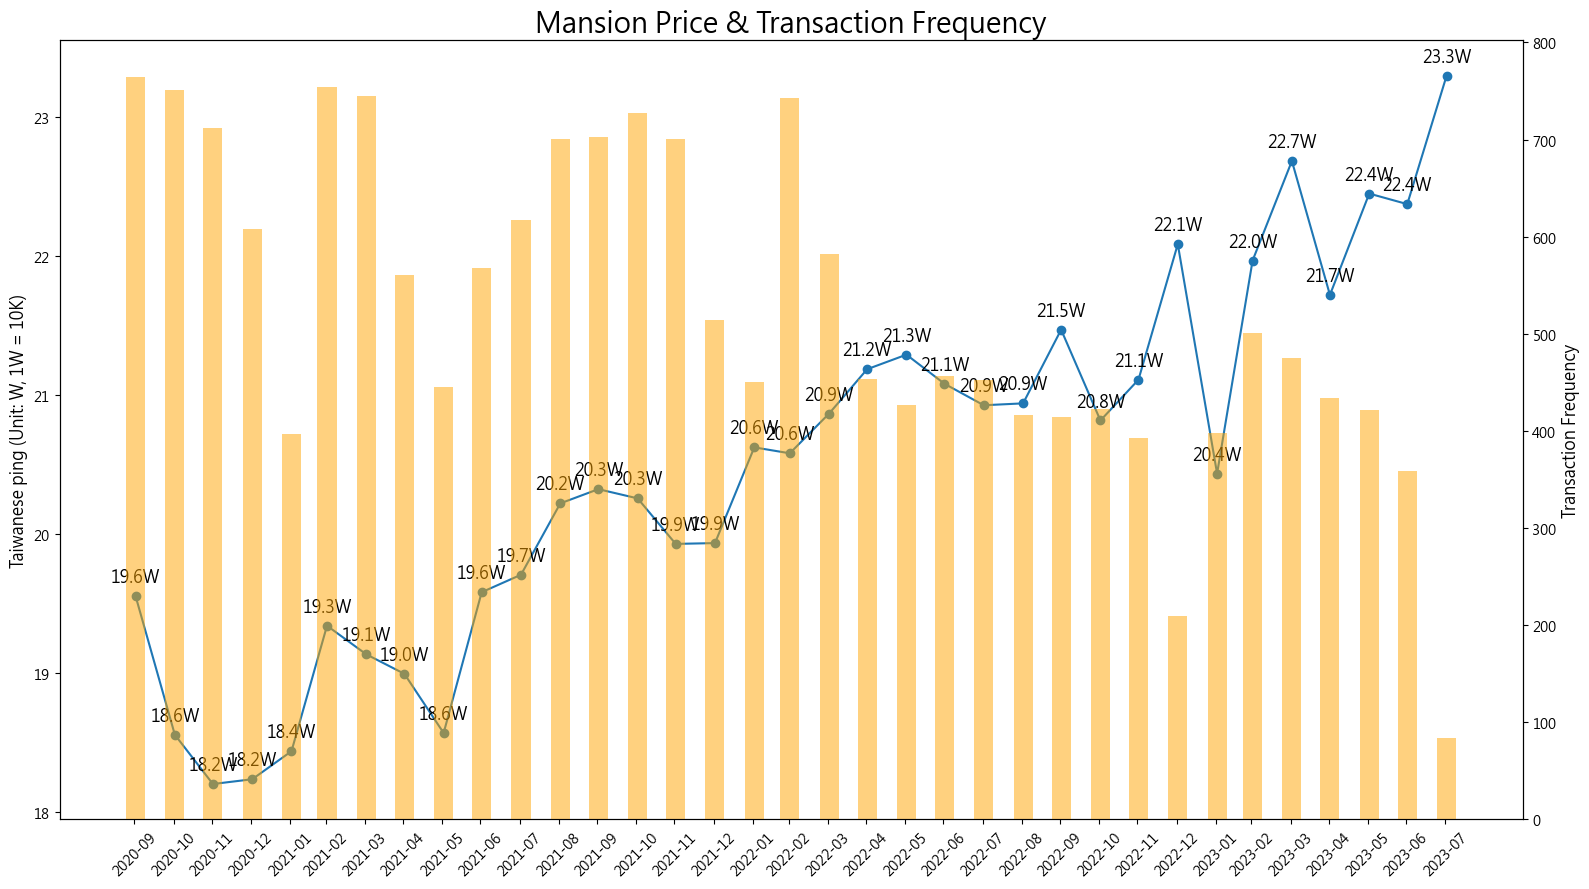

In [73]:
# Create a new DataFrame 'data2'
data2 = pd.DataFrame(data.groupby(['建物型態', 'Yearmonth'])['單價元坪'].mean()).reset_index()
data2['單價元坪'] = data2['單價元坪'] / 10000
property_dict = {'公寓(5樓含以下無電梯)': 'Apartment', 
                 '透天厝': 'Villa', 
                 '住宅大樓(11層含以上有電梯)': 'Residential Building', 
                 '華廈(10層含以下有電梯)':'Mansion'}

type_n = 0
for type in property_dict.keys():
    # Create a copy of data2
    data2_copy = data2[data2['建物型態'] == type]

    # Convert the Yearmonth column to datetime
    data2_copy.loc[:, 'Yearmonth'] = pd.to_datetime(data2_copy['Yearmonth'].astype(str), format='%Y-%m')

    # Sort the data by Yearmonth
    data2_copy = data2_copy.sort_values(by='Yearmonth')

    # Create a figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(16, 9))

    # Line chart for average price
    ax1.plot(data2_copy['Yearmonth'], data2_copy['單價元坪'], marker='o', linestyle='-', label='Average Price')
    ax1.set_ylabel('Taiwanese ping (Unit: W, 1W = 10K)', fontsize=12)
    title = f'{list(property_dict.values())[type_n]} Price & Transaction Frequency'
    type_n += 1
    ax1.set_title(title, fontsize=20)
    ax1.tick_params(axis='x', labelrotation=45)

    # Annotate the data points on the line chart with data labels
    for i, txt in enumerate(data2_copy['單價元坪']):
        ax1.annotate(f'{txt:.1f}W', (data2_copy['Yearmonth'].iloc[i], data2_copy['單價元坪'].iloc[i]),
                     textcoords="offset points", xytext=(0, 10), ha='center', size=12)

    # Create a second y-axis for the bar chart
    ax2 = ax1.twinx()
    
    # Bar chart for entry counts
    entry_counts = data[data['建物型態'] == type]['Yearmonth'].value_counts().sort_index()
    ax2.bar(data2_copy['Yearmonth'], entry_counts, alpha=0.5, color='orange', width=15, label='Entry Counts')
    ax2.set_ylabel('Transaction Frequency', fontsize=12)

    # Set the x-axis ticks and labels to display from September 2020 to August 2023
    ax1.set_xticks(pd.date_range('2020-09-01', '2023-08-01', freq='M'))
    ax1.set_xticklabels([date.strftime('%Y-%m') for date in pd.date_range('2020-09-01', '2023-08-01', freq='M')],
                        rotation=45)

    # Adjust layout to prevent label overlap
    fig.tight_layout()

    # # save the plot with title named
    # path_to_save_file = Path().absolute()/"PNG"/"Type"
    # path_to_save_file.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist
    # filename = f'{title}.png'
    # full_path = path_to_save_file/filename
    # plt.savefig(full_path)

    # Show the chart
    plt.show()

In [74]:
# for type in property_type:
#     # Create a copy of data2
#     data2_copy = data.copy()
#     data2_copy = data2_copy[data2_copy['建物型態'] == type].groupby(['建物型態', 'Yearmonth']).size().reset_index(name='Transaction_Count')
#     print(type)
#     display(data2_copy[['Yearmonth', 'Transaction_Count']].transpose())

data_count = data['建物型態'].value_counts()
data_count = pd.DataFrame(data_count).reset_index()
data_count['Weight'] = ((data_count['count'] / data_count['count'].sum())*100).round(2)
data_count['建物型態'] = data_count['建物型態'].replace(property_dict)
data_count['Weight'] = data_count['Weight'].apply(lambda x: f'{x}%')
data_count = data_count.rename(columns={'建物型態': 'Property Type'})
data_count


,Property Type,count,Weight
0,Residential Building,45930,37.73%
1,其他,31689,26.03%
2,Villa,18792,15.44%
3,Mansion,18360,15.08%
4,Apartment,6962,5.72%
5,廠辦,3,0.0%
6,店面(店鋪),3,0.0%
7,工廠,1,0.0%


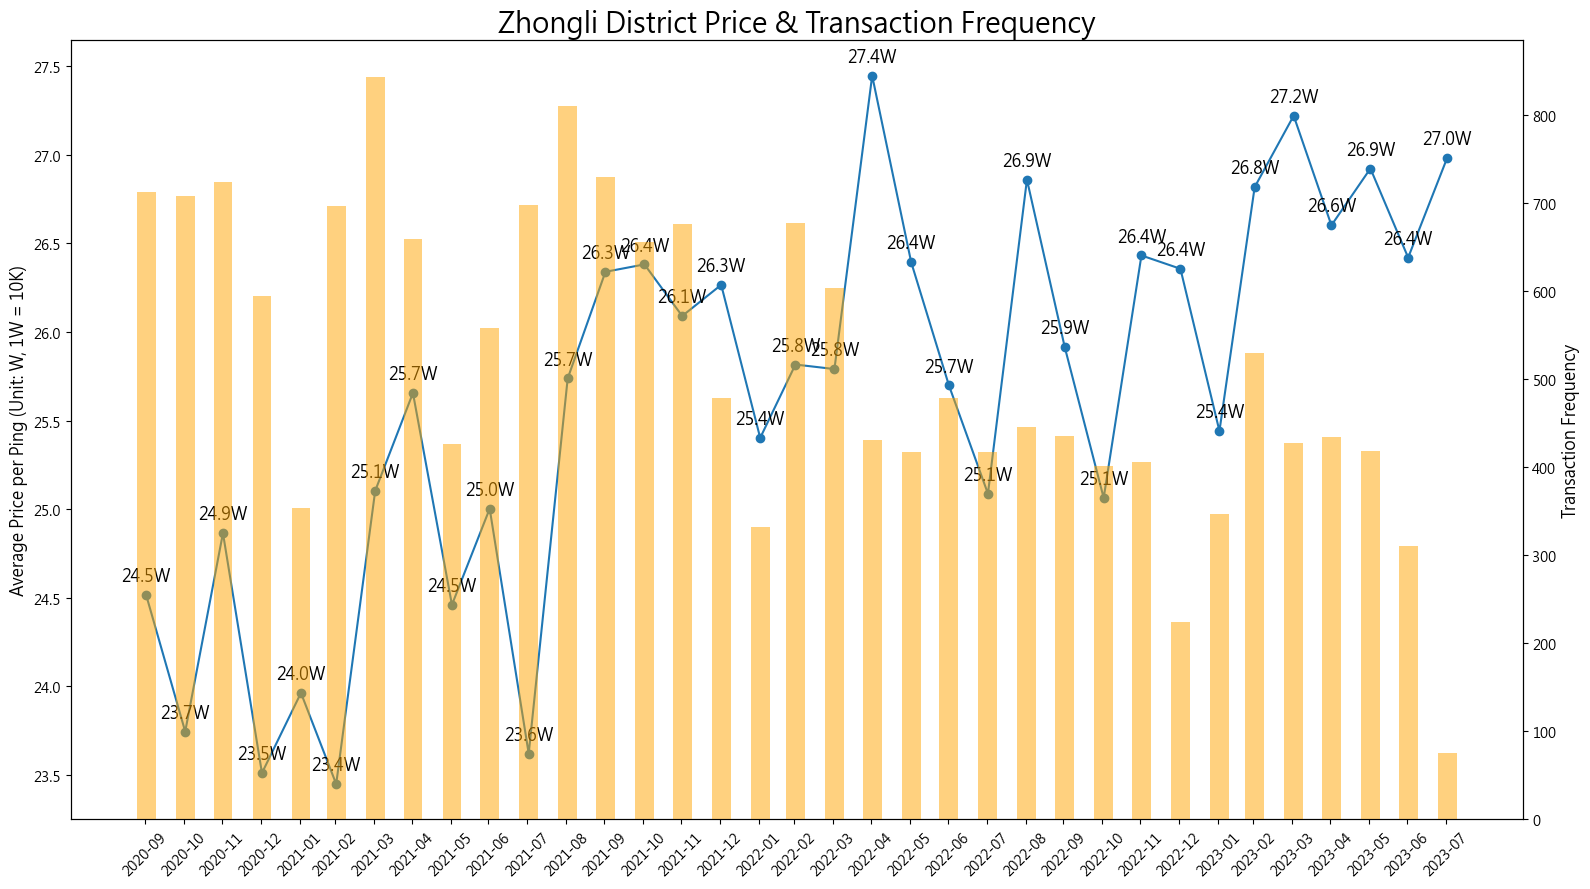

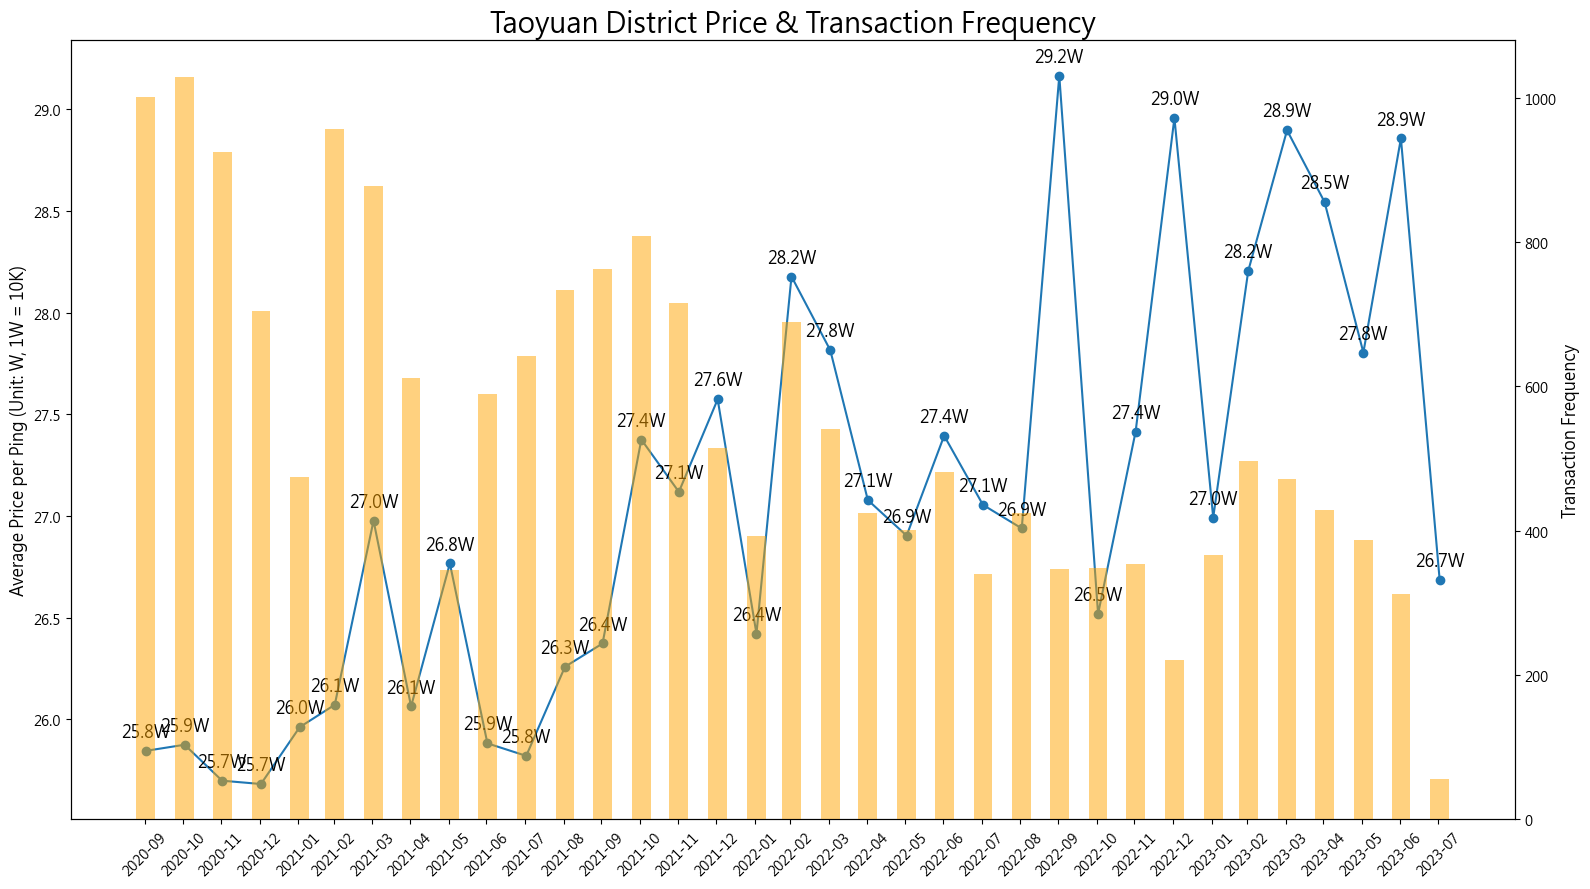

In [91]:
data = data[(data['建物型態'] == '公寓(5樓含以下無電梯)') | (data['建物型態'] == '透天厝') | (data['建物型態'] == '住宅大樓(11層含以上有電梯)') | (data['建物型態'] == '華廈(10層含以下有電梯)')]

# Create a new DataFrame 'data3'
data3 = pd.DataFrame(data.groupby(['鄉鎮市區', 'Yearmonth'])['單價元坪'].mean()).reset_index()
data3['單價元坪'] = data3['單價元坪'] / 10000
dist_dict = {'大溪區': 'Daxi District',
             '楊梅區': 'Yangmei District',
             '龍潭區': 'Longtan District',
             '平鎮區': 'Pingzhen District',
             '觀音區': 'Guanyin District',
             '蘆竹區': 'Luzhu District',
             '桃園區': 'Taoyuan District',
             '八德區': 'Bade District',
             '龜山區': 'Guishan District',
             '大園區': 'Dayuan District',
             '中壢區': 'Zhongli District',
             '新屋區': 'Xinwu District'}

for area in ['中壢區', '桃園區']:
    # Create a copy of data3
    data3_copy = data3.copy()
    
    # Filter data for the specific district
    data3_copy = data3_copy[data3_copy['鄉鎮市區'] == area]

    # Convert the Yearmonth column to datetime
    data3_copy['Yearmonth'] = pd.to_datetime(data3_copy['Yearmonth'].astype(str), format='%Y-%m')

    # Sort the data by Yearmonth
    data3_copy = data3_copy.sort_values(by='Yearmonth')

    # Create a figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(16, 9))

    # Line chart for average price
    ax1.plot(data3_copy['Yearmonth'], data3_copy['單價元坪'], marker='o', linestyle='-', label='Average Price')
    ax1.set_ylabel('Average Price per Ping (Unit: W, 1W = 10K)', fontsize=12)
    title = f'{dist_dict.get(area)} Price & Transaction Frequency'
    ax1.set_title(title, fontsize=20)
    ax1.tick_params(axis='x', labelrotation=45)

    # Create a second y-axis for the bar chart
    ax2 = ax1.twinx()
    
    # Bar chart for transaction counts
    entry_counts = data[data['鄉鎮市區'] == area]['Yearmonth'].value_counts().sort_index()
    ax2.bar(data3_copy['Yearmonth'], entry_counts, alpha=0.5, color='orange', width=15, label='Transaction Counts')
    ax2.set_ylabel('Transaction Frequency', fontsize=12)

    # Set the x-axis ticks and labels to display from September 2020 to August 2023
    ax1.set_xticks(pd.date_range('2020-09-01', '2023-08-01', freq='M'))
    ax1.set_xticklabels([date.strftime('%Y-%m') for date in pd.date_range('2020-09-01', '2023-08-01', freq='M')],
                        rotation=45)

    # Annotate the data points on the line chart with data labels
    for i, txt in enumerate(data3_copy['單價元坪']):
        ax1.annotate(f'{txt:.1f}W', (data3_copy['Yearmonth'].iloc[i], data3_copy['單價元坪'].iloc[i]),
                     textcoords="offset points", xytext=(0, 10), ha='center', size=12)

    # Adjust layout to prevent label overlap
    fig.tight_layout()

    # save the plot with title named
    path_to_save_file = Path().absolute()/"PNG"/"District"
    path_to_save_file.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist
    filename = f'{title}.png'
    full_path = path_to_save_file/filename
    plt.savefig(full_path)

    # Show the chart
    plt.show()


In [93]:
data_Zh_Tao = data[(data['鄉鎮市區'] == '中壢區') | (data['鄉鎮市區'] == '桃園區')]
data_Zh_Tao

,鄉鎮市區,土地位置建物門牌,土地移轉總面積平方公尺,交易年月日,總樓層數,建物型態,建物移轉總面積平方公尺,總價元,單價元平方公尺,主建物面積,土地移轉總面積坪,建物移轉總面積坪,單價元坪,主建物面積坪,Year,Quarter,Month,Day,Yearmonth
3,桃園區,文中路７４９巷４號五樓,18.12,2020-12-03,八層,華廈(10層含以下有電梯),99.74,4950000.0,49629,77.76,5.481300,30.171350,164063.5482,23.522400,2020,4,12,3,2020-12
5,桃園區,樹林八街３０之１號八樓,17.38,2020-12-01,十二層,住宅大樓(11層含以上有電梯),145.89,8700000.0,59634,56.74,5.257450,44.131725,197138.0772,17.163850,2020,4,12,1,2020-12
8,中壢區,自立三街２巷１２號,78.0,2020-12-01,四層,透天厝,276.37,15200000.0,54999,246.6,23.595000,83.601925,181815.6942,74.596500,2020,4,12,1,2020-12
64,中壢區,實踐路２２５號四樓之７２,4.32,2020-11-01,十層,華廈(10層含以下有電梯),28.400000000000002,1700000.0,59859,15.84,1.306800,8.591000,197881.8822,4.791600,2020,4,11,1,2020-11
79,中壢區,福州二街５１２號四樓之１,27.91,2020-11-02,十三層,住宅大樓(11層含以上有電梯),236.67000000000002,14500000.0,61267,100.84,8.442775,71.592675,202536.4486,30.504100,2020,4,11,2,2020-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12121,桃園區,桃園市桃園區正光一街１１１號十一樓,24.77,2020-10-08,十三層,住宅大樓(11層含以上有電梯),168.47,13980000.0,85752,84.4,7.492925,50.962175,283478.9616,25.531000,2020,4,10,8,2020-10
12122,桃園區,桃園市桃園區正光一街１０７號十一樓,30.72,2020-10-19,十五層,住宅大樓(11層含以上有電梯),202.61,17000000.0,86276,105.36,9.292800,61.289525,285211.2008,31.871400,2020,4,10,19,2020-10
12123,桃園區,桃園市桃園區正光一街１１１號十樓,24.77,2020-10-19,十三層,住宅大樓(11層含以上有電梯),168.47,14450000.0,87650,84.4,7.492925,50.962175,289753.3700,25.531000,2020,4,10,19,2020-10
12124,桃園區,桃園市桃園區正光一街１０７號六樓,30.72,2020-10-04,十五層,住宅大樓(11層含以上有電梯),202.61,17180000.0,86730,105.36,9.292800,61.289525,286712.0340,31.871400,2020,4,10,4,2020-10


In [77]:
## Export file as CSV
# path_to_save_file = Path().absolute()/"CSV"
# filename = '2020Q3-2023Q3_Taoyaun_property_data.csv' # save the plot with title named
# full_path = path_to_save_file/filename  # Constructing the full path

# data.to_csv(full_path, index=False)


In [78]:
# 針對青埔特區作分析
# 要搜尋的多個關鍵字
keywords = ['青芝段', '青山段', '青溪段', '青昇段', '青平段', '青峰段', '領航南路', '領航北路', '公園路二段', '公園路一段', '洽溪路', '青埔路']

# 在"土地位置建物門牌"欄位中找到包含特定關鍵字的資料
data_HSR = data[(data['鄉鎮市區'] == '中壢區') | (data['鄉鎮市區'] == '大園區') | (data['建物型態'] == '公寓(5樓含以下無電梯)') | (data['建物型態'] == '透天厝') | (data['建物型態'] == '住宅大樓(11層含以上有電梯)') | (data['建物型態'] == '華廈(10層含以下有電梯)')]

property_dict = {'公寓(5樓含以下無電梯)': 'Apartment', 
                 '透天厝': 'Villa', 
                 '住宅大樓(11層含以上有電梯)': 'Residential Building', 
                 '華廈(10層含以下有電梯)':'Mansion'}

# 在"土地位置建物門牌"欄位中找到包含多個關鍵字的資料
data_HSR = data_HSR[data_HSR['土地位置建物門牌'].str.contains('|'.join(keywords), na=False)]
data_HSR_detail = data_HSR[['土地移轉總面積平方公尺', '總價元', '主建物面積坪', '土地移轉總面積坪', '建物移轉總面積坪', '單價元坪']]
data_HSR_detail.loc[:,'總價元'] = data_HSR_detail['總價元'] / 10000
data_HSR_detail.loc[:,'單價元坪'] = data_HSR_detail['單價元坪'] / 10000

# data_HSR.describe()
np.round(data_HSR_detail, decimals = 2)
data_HSR_detail.describe().round(2)


,總價元,主建物面積坪,土地移轉總面積坪,建物移轉總面積坪,單價元坪
count,1243.00,1243.00,1243.00,1243.00,1243.00
mean,1831.79,27.27,8.87,58.54,33.88
std,659.86,10.37,4.01,18.85,7.54
min,95.00,0.00,0.00,17.67,2.05
25%,1402.50,19.71,6.64,43.97,29.35
50%,1698.00,26.57,8.55,55.55,32.53
75%,2180.00,31.70,10.40,70.98,38.79
max,6500.00,90.72,46.85,152.50,95.01


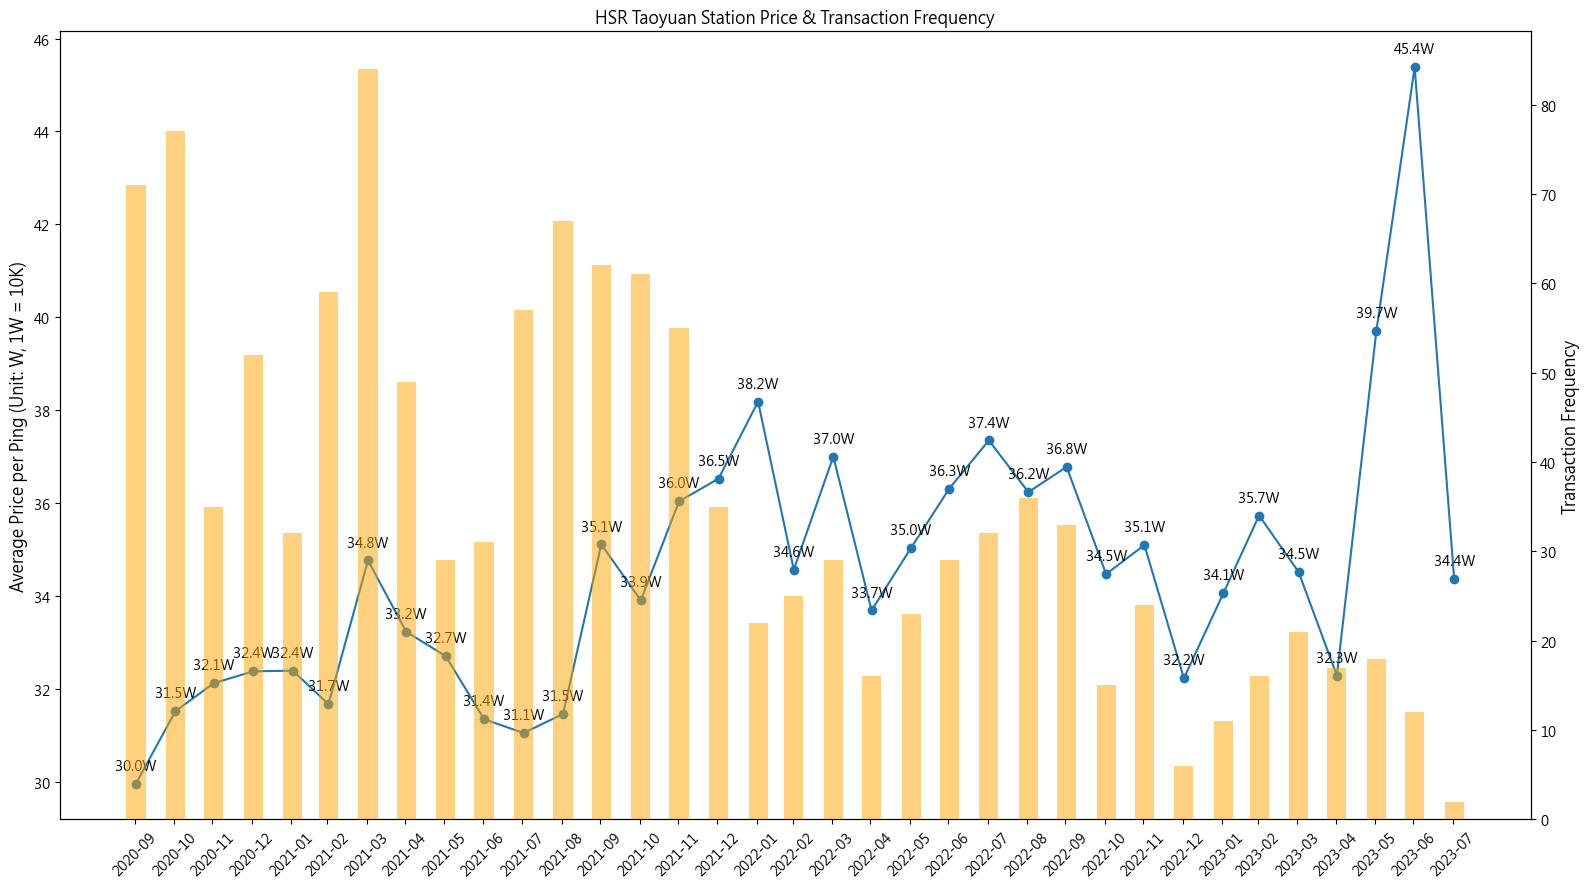

In [79]:
# Convert 'Yearmonth' to datetime
data_HSR['Yearmonth'] = pd.to_datetime(data_HSR['Yearmonth'].astype(str), errors='coerce')

# Drop rows with missing or NaT values (if needed)
data_bigger = data_HSR.dropna(subset=['Yearmonth'])

# Continue with the rest of your code...
average_price_per_sqm = data_bigger.groupby('Yearmonth')['單價元坪'].mean().reset_index()

# Convert 'Yearmonth' values to numeric
average_price_per_sqm = data_HSR.groupby('Yearmonth')['單價元坪'].mean().reset_index()
x_values = sorted(set(average_price_per_sqm['Yearmonth']))
x_values_numeric = date2num(x_values)

# Calculate transaction counts per month
entry_counts = data_HSR['Yearmonth'].value_counts().sort_index().reset_index()
entry_counts.columns = ['Yearmonth', 'Transaction Counts']

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(16, 9))

# 繪製平均價格的折線圖
line = ax1.plot(x_values_numeric, average_price_per_sqm['單價元坪'] / 10000, marker='o', label='Average Price')
ax1.set_ylabel('Average Price per Ping (Unit: W, 1W = 10K)', fontsize=12)
ax1.tick_params('y')

# 設定圖表標題和軸標籤
title = 'HSR Taoyuan Station Price & Transaction Frequency'
plt.title(title)

# 設定雙 Y 軸
ax2 = ax1.twinx()
ax2.bar(x_values_numeric, entry_counts['Transaction Counts'], alpha=0.5, color='orange', width=15, label='Transaction Counts')
ax2.set_ylabel('Transaction Frequency', fontsize=12)

# Set the x-axis ticks and labels to display from September 2020 to August 2023
ax1.set_xticks(pd.date_range('2020-09-01', '2023-08-01', freq='M'))
ax1.set_xticklabels([date.strftime('%Y-%m') for date in pd.date_range('2020-09-01', '2023-08-01', freq='M')],
                    rotation=45)

# Add data labels to the line plot
for i, txt in enumerate(average_price_per_sqm['單價元坪'] / 10000):
    ax1.annotate(f'{round(txt, 1)}W', (x_values_numeric[i], txt),
                 textcoords="offset points", xytext=(0, 10), ha='center')
    
plt.xticks(rotation=45)
plt.tight_layout()

# # save the plot with title named
# path_to_save_file = Path().absolute()/"PNG"/"Redistricting"
# path_to_save_file.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist
# filename = f'{title}.png'
# full_path = path_to_save_file/filename
# plt.savefig(full_path)


# 顯示圖表
plt.show()


In [80]:
for type in list(property_dict.keys()):
    # Step 1: 篩選出建物型態為住宅大樓的數據
    data_HSR_detail = data_HSR[data_HSR['建物型態'] == type]
    data_HSR_detail.loc[:,'總價元'] = data_HSR_detail['總價元']/10000
    data_HSR_detail.loc[:,'單價元坪'] = data_HSR_detail['單價元坪']/10000
    data_HSR_detail = data_HSR_detail[['總價元', '建物移轉總面積坪', '單價元坪']]
    if data_HSR_detail[['總價元', '建物移轉總面積坪', '單價元坪']].isnull().all().all():
        continue  # 如果是，則跳過該類型的輸出
    print(type)
    display(data_HSR_detail.describe().round(1))


透天厝


,總價元,建物移轉總面積坪,單價元坪
count,13.0,13.0,13.0
mean,2154.5,75.8,27.5
std,835.7,17.2,8.4
min,95.0,46.3,2.1
25%,1850.0,65.9,26.0
50%,2000.0,75.0,29.6
75%,2706.0,86.1,31.9
max,3500.0,109.8,35.8


住宅大樓(11層含以上有電梯)


,總價元,建物移轉總面積坪,單價元坪
count,1022.0,1022.0,1022.0
mean,1915.1,59.7,35.0
std,659.4,19.0,7.6
min,405.0,17.7,17.0
25%,1510.0,45.1,30.3
50%,1777.5,56.5,34.0
75%,2250.0,73.3,39.8
max,6500.0,152.5,95.0


華廈(10層含以下有電梯)


,總價元,建物移轉總面積坪,單價元坪
count,208.0,208.0,208.0
mean,1402.5,51.6,28.8
std,448.5,16.2,4.5
min,608.0,18.1,17.9
25%,1107.5,39.4,26.1
50%,1333.0,47.9,29.4
75%,1592.5,62.5,31.0
max,3100.0,105.1,46.5


In [81]:
import math

# 初始化一個空的 DataFrame
result_data_HSR = pd.DataFrame(columns=['Type', '2020Q4 avg price', '2023Q2 avg price', 'Growth Difference'])

for type in list(property_dict.keys()):
    # Step 1: 篩選出建物型態為住宅大樓的數據
    residential_df = data_HSR[data_HSR['建物型態'] == type]

    # Step 3: 計算2020年第四季和2023年第二季的平均價格
    avg_price_2020_Q4 = residential_df[(residential_df['Year'] == 2020) & (residential_df['Quarter'] == 4)]['單價元坪'].mean() / 10000
    avg_price_2023_Q2 = residential_df[(residential_df['Year'] == 2023) & (residential_df['Quarter'] == 2)]['單價元坪'].mean() / 10000

    # 轉換為小數點兩位
    avg_price_2020_Q4 = round(avg_price_2020_Q4, 2)
    avg_price_2023_Q2 = round(avg_price_2023_Q2, 2)

    # Step 4: 計算成長差異
    if not math.isnan(avg_price_2023_Q2):
        price_growth_difference = ((avg_price_2023_Q2 - avg_price_2020_Q4) / avg_price_2023_Q2) * 100

        # 轉換成百分比，並且保留小數點兩位
        price_growth_difference = round(price_growth_difference, 2)

        # Step 5: 檢查 Growth difference 是否為 NaN，如果不是，加入到 DataFrame
        if not math.isnan(price_growth_difference):
            # 檢查是否為空的 DataFrame
            if result_data_HSR.empty:
                result_data_HSR = pd.DataFrame([{
                    'Type': property_dict.get(type),
                    '2020Q4 avg price': avg_price_2020_Q4,
                    '2023Q2 avg price': avg_price_2023_Q2,
                    'Growth Difference': f"{price_growth_difference}%"
                }])
            else:
                # 合併非空的 DataFrame
                result_data_HSR = pd.concat([result_data_HSR, pd.DataFrame([{
                    'Type': property_dict.get(type),
                    '2020Q4 avg price': avg_price_2020_Q4,
                    '2023Q2 avg price': avg_price_2023_Q2,
                    'Growth Difference': f"{price_growth_difference}%"
                }])], ignore_index=True)

# 輸出最終的 DataFrame
result_data_HSR = result_data_HSR[(result_data_HSR['Type'] == 'Residential Building') | (result_data_HSR['Type'] == 'Mansion') ]
result_data_HSR

,Type,2020Q4 avg price,2023Q2 avg price,Growth Difference
1,Residential Building,31.91,37.57,15.07%
2,Mansion,28.22,29.75,5.14%


In [82]:
# 針對八德八廓特區作分析
# 要搜尋的多個關鍵字
keywords = ['連城段', '興仁段', '福興段', '豐田段', '興豐段', '瑞德段', '建德路', '豐德路', '長興路', '中山路', '興豐路', '介壽路', '豐德路', '廣興路', '建國路', '介壽路二段']

# 在"土地位置建物門牌"欄位中找到包含特定關鍵字的資料
data_bigger = data[data['鄉鎮市區'] == '八德區']

# 在"土地位置建物門牌"欄位中找到包含多個關鍵字的資料
data_bigger = data_bigger[data_bigger['土地位置建物門牌'].str.contains('|'.join(keywords), na=False)]
data_bigger_detail = data_bigger[['土地移轉總面積平方公尺', '總價元', '主建物面積坪', '土地移轉總面積坪', '建物移轉總面積坪', '單價元坪']]
data_bigger_detail.loc[:,'總價元'] = data_bigger_detail['總價元'] / 10000
data_bigger_detail.loc[:,'單價元坪'] = data_bigger_detail['單價元坪'] / 10000

# data_HSR.describe()
data_bigger_detail.describe().round(2)


,總價元,主建物面積坪,土地移轉總面積坪,建物移轉總面積坪,單價元坪
count,1395.00,1395.00,1395.00,1395.00,1395.00
mean,1387.35,39.09,21.60,69.14,22.45
std,12632.25,325.93,259.76,848.28,9.82
min,52.00,0.00,0.00,2.83,2.42
25%,570.00,19.52,6.50,29.09,17.89
50%,885.00,24.32,7.95,42.03,22.26
75%,1196.50,30.99,14.50,51.23,26.06
max,468000.00,12084.21,9558.49,31676.72,265.06


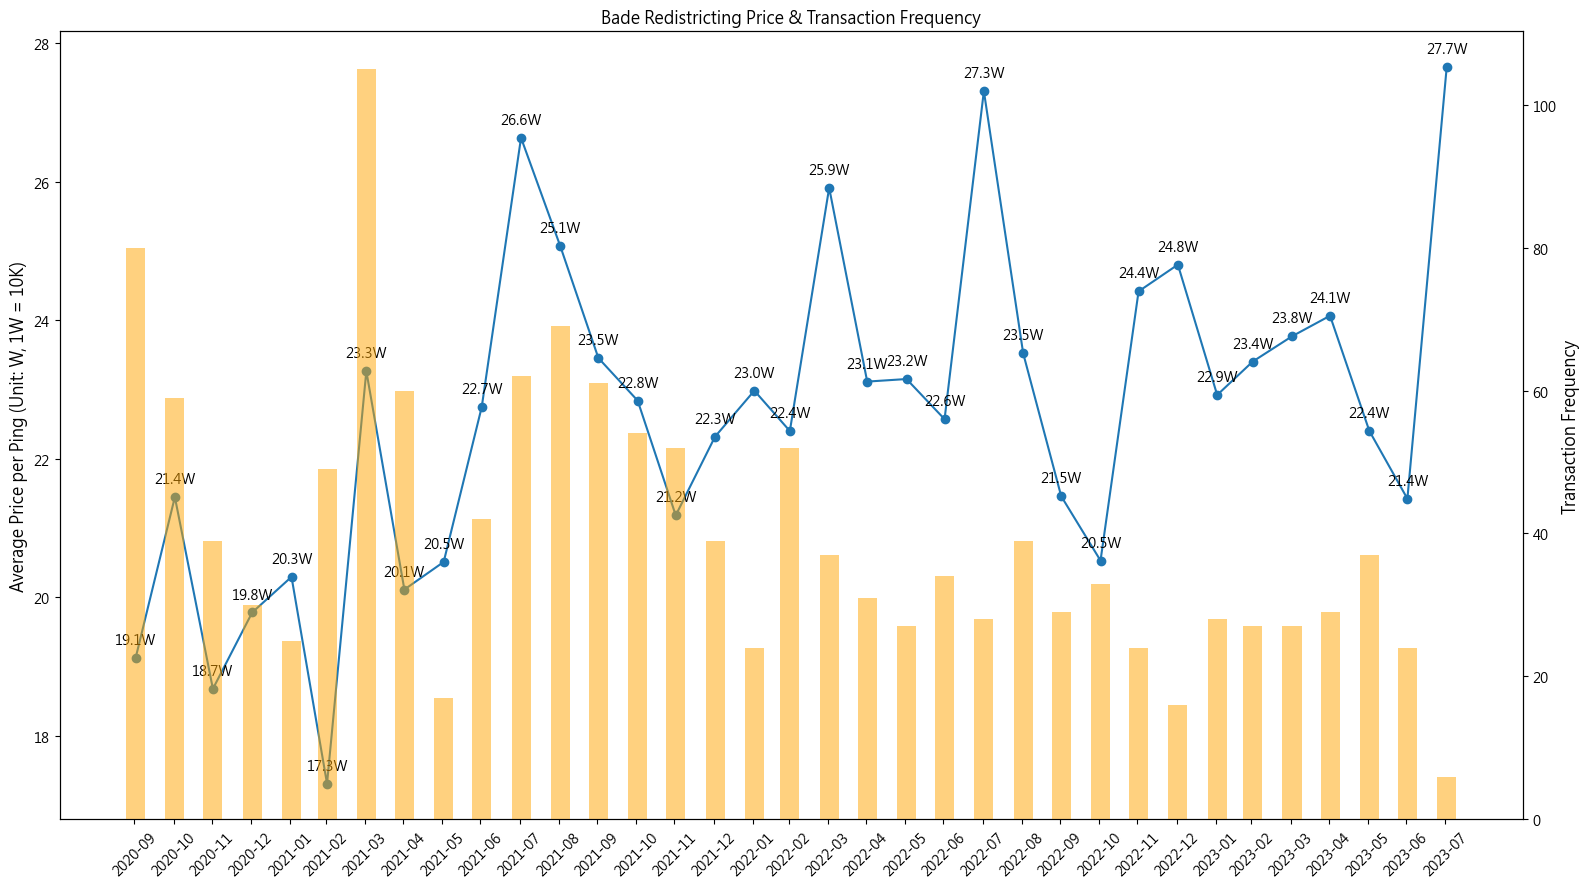

In [83]:
# Convert 'Yearmonth' to datetime
data_bigger['Yearmonth'] = pd.to_datetime(data_bigger['Yearmonth'].astype(str), errors='coerce')

# Drop rows with missing or NaT values (if needed)
data_bigger = data_bigger.dropna(subset=['Yearmonth'])

# Continue with the rest of your code...
average_price_per_sqm = data_bigger.groupby('Yearmonth')['單價元坪'].mean().reset_index()

# Convert 'Yearmonth' values to numeric
average_price_per_sqm = data_bigger.groupby('Yearmonth')['單價元坪'].mean().reset_index()
x_values = sorted(set(average_price_per_sqm['Yearmonth']))
x_values_numeric = date2num(x_values)

# Calculate transaction counts per month
entry_counts = data_bigger['Yearmonth'].value_counts().sort_index().reset_index()
entry_counts.columns = ['Yearmonth', 'Transaction Counts']

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(16, 9))

# 繪製平均價格的折線圖
line = ax1.plot(x_values_numeric, average_price_per_sqm['單價元坪'] / 10000, marker='o', label='Average Price')
ax1.set_ylabel('Average Price per Ping (Unit: W, 1W = 10K)', fontsize=12)
ax1.tick_params('y')

# 設定圖表標題和軸標籤
title = 'Bade Redistricting Price & Transaction Frequency'
plt.title(title)

# 設定雙 Y 軸
ax2 = ax1.twinx()
ax2.bar(x_values_numeric, entry_counts['Transaction Counts'], alpha=0.5, color='orange', width=15, label='Transaction Counts')
ax2.set_ylabel('Transaction Frequency', fontsize=12)

# Set the x-axis ticks and labels to display from September 2020 to August 2023
ax1.set_xticks(pd.date_range('2020-09-01', '2023-08-01', freq='M'))
ax1.set_xticklabels([date.strftime('%Y-%m') for date in pd.date_range('2020-09-01', '2023-08-01', freq='M')],
                    rotation=45)

# Add data labels to the line plot
for i, txt in enumerate(average_price_per_sqm['單價元坪'] / 10000):
    ax1.annotate(f'{round(txt, 1)}W', (x_values_numeric[i], txt),
                 textcoords="offset points", xytext=(0, 10), ha='center')

# 顯示圖表
plt.xticks(rotation=45)
plt.tight_layout()

# save the plot with title named
path_to_save_file = Path().absolute()/"PNG"/"Redistricting"
path_to_save_file.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist
filename = f'{title}.png'
full_path = path_to_save_file/filename
plt.savefig(full_path)

plt.show()


In [84]:
for type in list(property_dict.keys()):
    # Step 1: 篩選出建物型態為住宅大樓的數據
    data_bigger_detail = data_bigger[data_bigger['建物型態'] == type]
    data_bigger_detail.loc[:,'總價元'] = data_bigger_detail['總價元']/10000
    data_bigger_detail.loc[:,'單價元坪'] = data_bigger_detail['單價元坪']/10000
    data_bigger_detail = data_bigger_detail[['總價元', '建物移轉總面積坪', '單價元坪']]
    if data_bigger_detail[['總價元', '建物移轉總面積坪', '單價元坪']].isnull().all().all():
        continue  # 如果是，則跳過該類型的輸出
    print(type)
    display(data_bigger_detail.describe().round(1))

公寓(5樓含以下無電梯)


,總價元,建物移轉總面積坪,單價元坪
count,250.0,250.0,250.0
mean,441.1,27.3,16.3
std,153.1,5.0,5.1
min,63.3,4.8,3.1
25%,335.8,25.4,12.8
50%,422.5,25.4,15.9
75%,517.2,28.8,18.5
max,1600.0,51.3,49.0


透天厝


,總價元,建物移轉總面積坪,單價元坪
count,324.0,324.0,324.0
mean,2814.1,152.8,24.3
std,26174.5,1759.4,17.0
min,52.0,2.8,2.4
25%,511.2,26.6,18.0
50%,830.0,34.9,22.6
75%,1200.0,58.2,28.4
max,468000.0,31676.7,265.1


住宅大樓(11層含以上有電梯)


,總價元,建物移轉總面積坪,單價元坪
count,753.0,753.0,753.0
mean,1158.4,50.1,24.2
std,494.4,16.7,5.0
min,295.0,15.2,12.4
25%,874.0,40.8,20.6
50%,1040.0,45.1,24.4
75%,1300.0,55.8,26.6
max,5199.0,144.4,53.8


華廈(10層含以下有電梯)


,總價元,建物移轉總面積坪,單價元坪
count,68.0,68.0,68.0
mean,603.5,35.6,17.2
std,185.2,9.3,4.3
min,225.0,17.0,10.4
25%,497.5,29.3,14.6
50%,619.0,38.2,16.4
75%,719.2,41.7,18.6
max,1395.0,57.3,35.9


In [85]:
import math

# 初始化一個空的 DataFrame
result_data_bigger = pd.DataFrame(columns=['Type', '2020Q4 avg price', '2023Q2 avg price', 'Growth Difference'])

for type in list(property_dict.keys()):
    # Step 1: 篩選出建物型態為住宅大樓的數據
    residential_df = data_bigger[data_bigger['建物型態'] == type]

    # Step 3: 計算2020年第四季和2023年第二季的平均價格
    avg_price_2020_Q4 = residential_df[(residential_df['Year'] == 2020) & (residential_df['Quarter'] == 4)]['單價元坪'].mean() / 10000
    avg_price_2023_Q2 = residential_df[(residential_df['Year'] == 2023) & (residential_df['Quarter'] == 2)]['單價元坪'].mean() / 10000

    # 轉換為小數點兩位
    avg_price_2020_Q4 = round(avg_price_2020_Q4, 2)
    avg_price_2023_Q2 = round(avg_price_2023_Q2, 2)

    # Step 4: 計算成長差異
    if not math.isnan(avg_price_2023_Q2):
        price_growth_difference = ((avg_price_2023_Q2 - avg_price_2020_Q4) / avg_price_2023_Q2) * 100

        # 轉換成百分比，並且保留小數點兩位
        price_growth_difference = round(price_growth_difference, 2)

        # Step 5: 檢查 Growth difference 是否為 NaN，如果不是，加入到 DataFrame
        if not math.isnan(price_growth_difference):
            # 檢查是否為空的 DataFrame
            if result_data_bigger.empty:
                result_data_bigger = pd.DataFrame([{
                    'Type': property_dict.get(type),
                    '2020Q4 avg price': avg_price_2020_Q4,
                    '2023Q2 avg price': avg_price_2023_Q2,
                    'Growth Difference': f"{price_growth_difference}%"
                }])
            else:
                # 合併非空的 DataFrame
                result_data_bigger = pd.concat([result_data_bigger, pd.DataFrame([{
                    'Type': property_dict.get(type),
                    '2020Q4 avg price': avg_price_2020_Q4,
                    '2023Q2 avg price': avg_price_2023_Q2,
                    'Growth Difference': f"{price_growth_difference}%"
                }])], ignore_index=True)

# 輸出最終的 DataFrame
result_data_bigger = result_data_bigger[(result_data_bigger['Type'] == 'Residential Building') | (result_data_bigger['Type'] == 'Mansion') | (result_data_bigger['Type'] == 'Villa')]
result_data_bigger

,Type,2020Q4 avg price,2023Q2 avg price,Growth Difference
1,Villa,20.78,26.03,20.17%
2,Residential Building,21.04,24.26,13.27%
3,Mansion,14.51,17.68,17.93%


In [94]:
# 針對八德擴大特區作分析
# 要搜尋的多個關鍵字
keywords = ['大明段', '桃鷹路', '大明里', '桃鷹段', '大樹林段', '鳳福段']

# 在"土地位置建物門牌"欄位中找到包含特定關鍵字的資料
data_bade_Tao = data[(data['鄉鎮市區'] == '八德區') | (data['鄉鎮市區'] == '桃園區') ]

# 在"土地位置建物門牌"欄位中找到包含多個關鍵字的資料
data_bade_Tao = data_bade_Tao[data_bade_Tao['土地位置建物門牌'].str.contains('|'.join(keywords), na=False)]
ddata_bade_Tao_detail = data_bade_Tao[['土地移轉總面積平方公尺', '總價元', '主建物面積坪', '土地移轉總面積坪', '建物移轉總面積坪', '單價元坪']]
ddata_bade_Tao_detail.loc[:,'總價元'] = ddata_bade_Tao_detail['總價元'] / 10000
ddata_bade_Tao_detail.loc[:,'單價元坪'] = ddata_bade_Tao_detail['單價元坪'] / 10000

# data_HSR.describe()
ddata_bade_Tao_detail.describe().round(2)


,總價元,主建物面積坪,土地移轉總面積坪,建物移轉總面積坪,單價元坪
count,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN


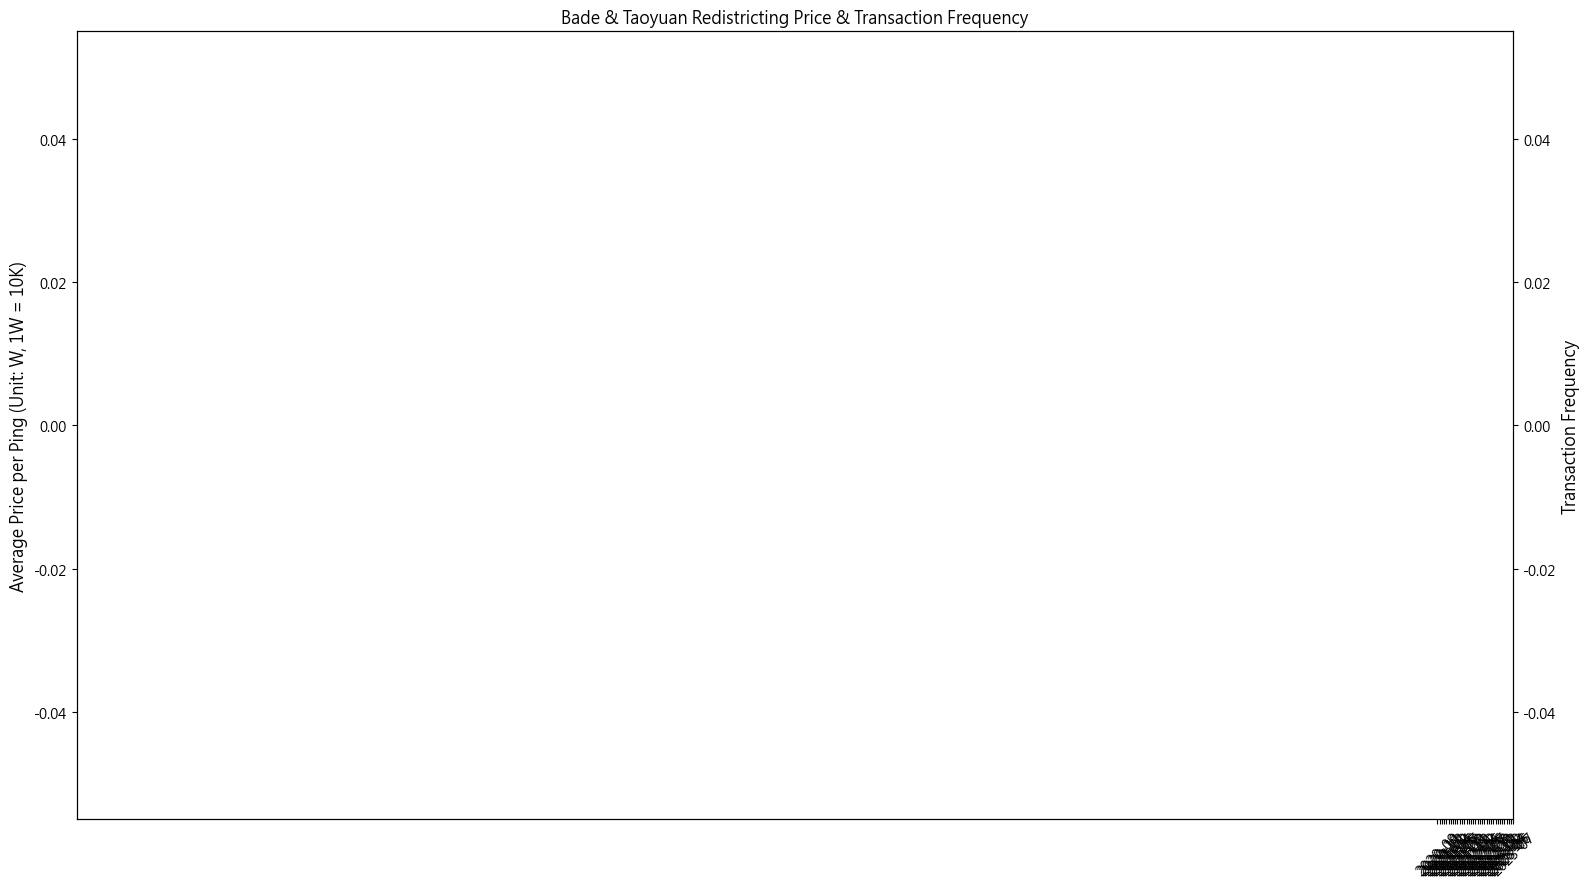

In [87]:
# Convert 'Yearmonth' to datetime
data_bade_Tao['Yearmonth'] = pd.to_datetime(data_bade_Tao['Yearmonth'].astype(str), errors='coerce')

# Drop rows with missing or NaT values (if needed)
data_bade_Tao = data_bade_Tao.dropna(subset=['Yearmonth'])

# Continue with the rest of your code...
average_price_per_sqm = data_bade_Tao.groupby('Yearmonth')['單價元坪'].mean().reset_index()

# Convert 'Yearmonth' values to numeric
average_price_per_sqm = data_bade_Tao.groupby('Yearmonth')['單價元坪'].mean().reset_index()
x_values = sorted(set(average_price_per_sqm['Yearmonth']))
x_values_numeric = date2num(x_values)

# Calculate transaction counts per month
entry_counts = data_bade_Tao['Yearmonth'].value_counts().sort_index().reset_index()
entry_counts.columns = ['Yearmonth', 'Transaction Counts']

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(16, 9))

# 繪製平均價格的折線圖
line = ax1.plot(x_values_numeric, average_price_per_sqm['單價元坪'] / 10000, marker='o', label='Average Price')
ax1.set_ylabel('Average Price per Ping (Unit: W, 1W = 10K)', fontsize=12)
ax1.tick_params('y')

# 設定圖表標題和軸標籤
title = 'Bade & Taoyuan Redistricting Price & Transaction Frequency'
plt.title(title)

# 設定雙 Y 軸
ax2 = ax1.twinx()
ax2.bar(x_values_numeric, entry_counts['Transaction Counts'], alpha=0.5, color='orange', width=15, label='Transaction Counts')
ax2.set_ylabel('Transaction Frequency', fontsize=12)

# Set the x-axis ticks and labels to display from September 2020 to August 2023
ax1.set_xticks(pd.date_range('2020-09-01', '2023-08-01', freq='M'))
ax1.set_xticklabels([date.strftime('%Y-%m') for date in pd.date_range('2020-09-01', '2023-08-01', freq='M')],
                    rotation=45)

# Add data labels to the line plot
for i, txt in enumerate(average_price_per_sqm['單價元坪'] / 10000):
    ax1.annotate(f'{round(txt, 1)}W', (x_values_numeric[i], txt),
                 textcoords="offset points", xytext=(0, 10), ha='center')

# 顯示圖表
plt.xticks(rotation=45)
plt.tight_layout()

# save the plot with title named
path_to_save_file = Path().absolute()/"PNG"/"Redistricting"
path_to_save_file.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist
filename = f'{title}.png'
full_path = path_to_save_file/filename
plt.savefig(full_path)

plt.show()


In [88]:
# for type in list(property_dict.keys()):
#     # Step 1: 篩選出建物型態為住宅大樓的數據
#     data_bade_Tao_detail = data_bade_Tao[data_bade_Tao['建物型態'] == type]
#     data_bade_Tao_detail.loc[:,'總價元'] = data_bade_Tao_detail['總價元']/10000
#     data_bade_Tao_detail.loc[:,'單價元坪'] = data_bade_Tao_detail['單價元坪']/10000
#     data_bade_Tao_detail = data_bade_Tao_detail[['總價元', '建物移轉總面積坪', '單價元坪']]
#     if data_bade_Tao_detail[['總價元', '建物移轉總面積坪', '單價元坪']].isnull().all().all():
#         continue  # 如果是，則跳過該類型的輸出
#     print(type)
#     display(data_bade_Tao_detail.describe().round(1))


In [89]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

url = 'https://www.numbeo.com/property-investment/rankings_by_country.jsp'
re = requests.get(url)
soup = BeautifulSoup(re.text, 'html.parser')

soup = soup.select('tbody')[0].select('tr')

country_list = []
price_to_income_ratio_list = []

for i in range(len(soup)):
    country = soup[i].select('td[class="cityOrCountryInIndicesTable"]')[0].text
    price_to_income_ratio = soup[i].select('td[style="text-align: right"]')[0].text
    country_list.append(country)
    price_to_income_ratio_list.append(price_to_income_ratio)
    # print(i+1, country, price_to_income_ratio, sep = '/')

df = pd.DataFrame(list(zip(country_list, price_to_income_ratio_list)), columns=['Country', 'Price_to_Income_Ratio'])
df.index = range(1, len(df) + 1)


In [90]:
df = df[(df['Country'] == 'Taiwan') | 
        (df['Country'] == 'Syria') | 
        (df['Country'] == 'Hong Kong (China)') | 
        (df['Country'] == 'Cameroon') | 
        (df['Country'] == 'China') |
        (df['Country'] == 'South Korea') |
        (df['Country'] == 'Indonesia') |
        (df['Country'] == 'Singapore') |
        (df['Country'] == 'Egypt') |
        (df['Country'] == 'Australia') |
        (df['Country'] == 'Japan') |
        (df['Country'] == 'Malaysia') |
        (df['Country'] == 'United Kingdom') |
        (df['Country'] == 'United Arab Emirates') ]
df

,Country,Price_to_Income_Ratio
1,Syria,99.5
2,Hong Kong (China),42.1
3,Cameroon,41.7
6,China,33.0
15,Taiwan,22.1
16,South Korea,20.3
17,Indonesia,19.7
28,Singapore,15.7
53,Egypt,12.5
74,Australia,9.9
